In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import plotting

2024-10-03 19:59:54.781945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 19:59:54.797817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 19:59:54.802762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 19:59:54.816180: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 19:59:55.816807: W tensorflow/compiler/tf2

In [2]:
# force gpu use
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

I0000 00:00:1727974798.286965   35257 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727974798.325131   35257 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727974798.327058   35257 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# quite good with @tf.fuinction
@tf.function
def custom_activation(x):
    return tf.sin(x)

In [4]:
def setup_model() -> tf.keras.models.Sequential:
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input((2,)),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=1),
        ]
    )

    model.summary()
    model.compile(optimizer="Adam", loss="mean_squared_error")
    return model, tf.keras.optimizers.Adam(learning_rate=0.001)

$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}=f$

In [5]:
tf_pi = tf.constant(np.pi)

def real_u(area):
    area = np.array(area)
    if len(area.shape) >= 3:
        x = area[0]
        y = area[1]
        return np.sin(np.pi * x) * np.sin(np.pi * y)
    else:
        return np.array([np.sin(np.pi * x) * np.sin(np.pi * y)  for x, y in area])

# TODO: experiment with tf function and parameters
@tf.function
def f(x, y):
    return -2 * tf_pi * tf_pi * tf.sin(tf_pi * y) * tf.sin(tf_pi * x)

I0000 00:00:1727974798.403155   35257 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727974798.404813   35257 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727974798.406461   35257 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727974798.532355   35257 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Params

In [6]:
grid_size = (50, 50)
plotting_grid_size = (200, 200)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)
koef = 10

EPOCHS = 6000
EPRINT = 500
LOSS = 1e-4  #1e-4

checkpoint_path = "../models/model1.weights.h5"

In [7]:
def get_area(grid_size, x_limits, y_limits):
    x = np.linspace(x_limits[0], x_limits[1], grid_size[0], dtype=np.float32)[1:-1]
    y = np.linspace(y_limits[0], y_limits[1], grid_size[1], dtype=np.float32)[1:-1]

    # FIXME: area inside points is in border??
    return mesh_to_pairs(np.meshgrid(x, y))


def get_border(border_grid_size, x_limits, y_limits):
    x = np.linspace(x_limits[0], x_limits[1],
                    border_grid_size[0], dtype=np.float32)
    y = np.linspace(y_limits[0], y_limits[1],
                    border_grid_size[1], dtype=np.float32)
    x_first = np.full(border_grid_size[0], x[0])
    x_last = np.full(border_grid_size[0], x[-1])
    y_first = np.full(border_grid_size[1], y[0])
    y_last = np.full(border_grid_size[1], y[-1])
    border = np.concatenate((np.column_stack((x_first, x)), np.column_stack(
        (x_last, x)), np.column_stack((y, y_first))[1:-1], np.column_stack((y, y_last))[1:-1]))
    return border


def mesh_to_pairs(meshgrid: list[np.ndarray]):
    return np.column_stack((meshgrid[0].flatten(), meshgrid[1].flatten()))

In [8]:
@tf.function
def ode_system(coord, border, net):
    # set type to avoid overcalculations
    # border = tf.constant(border, dtype=tf.float32)
    # coord = tf.constant(coord, dtype=tf.float32)
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch(coord)
        with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape1:
            tape1.watch(coord)
            u = net(coord)
        grad_u = tape1.gradient(u, coord)
        du_dx = grad_u[..., 0]
        du_dy = grad_u[..., 1]
        del tape1

    d2u_dx2 = tape.gradient(du_dx, coord)[..., 0]
    d2u_dy2 = tape.gradient(du_dy, coord)[..., 1]
    del tape
    
    x = coord[..., 0]
    y = coord[..., 1]
    ode_loss = d2u_dx2 + d2u_dy2 - f(x, y)
    IC_loss = net(border) - tf.zeros((len(border), 1))

    square_loss = tf.square(ode_loss) + koef * tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

In [9]:
# train model
@tf.function
def train_with_loss(train_coord, border, net, optm):
    for itr in tf.range(0, EPOCHS):
        with tf.GradientTape() as tape:
            train_loss = ode_system(train_coord, border, net)
            # train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, net.trainable_variables)
        optm.apply_gradients(zip(grad_w, net.trainable_variables))
        del tape

        if itr % EPRINT == 0:
            # USE TF.PRINT()!!!
            tf.print("epoch:", itr, "loss:", train_loss)  #.numpy())
            if train_loss < LOSS:
                break

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 0 loss: 0.00177648198
epoch: 500 loss: 0.000689986162
epoch: 1000 loss: 0.000701690151
epoch: 1500 loss: 0.00136482203
epoch: 2000 loss: 0.000782761839
epoch: 2500 loss: 0.00145008671
epoch: 3000 loss: 0.00342207798
epoch: 3500 loss: 0.00229211757
epoch: 4000 loss: 0.00163551234
epoch: 4500 loss: 0.00155457167
epoch: 5000 loss: 0.00130623172
epoch: 5500 loss: 0.00164655363
epoch: 6000 loss: 0.000881289
epoch: 6500 loss: 0.00161187607
epoch: 7000 loss: 0.000500576221
epoch: 7500 loss: 0.00285561103
epoch: 8000 loss: 0.000527172873
epoch: 8500 loss: 0.00134966662
epoch: 9000 loss: 0.00198795041
epoch: 9500 loss: 0.00101849786
epoch: 10000 loss: 0.00131003198
epoch: 10500 loss: 0.000429664127
epoch: 11000 loss: 0.00173816714
epoch: 11500 loss: 0.000829127617


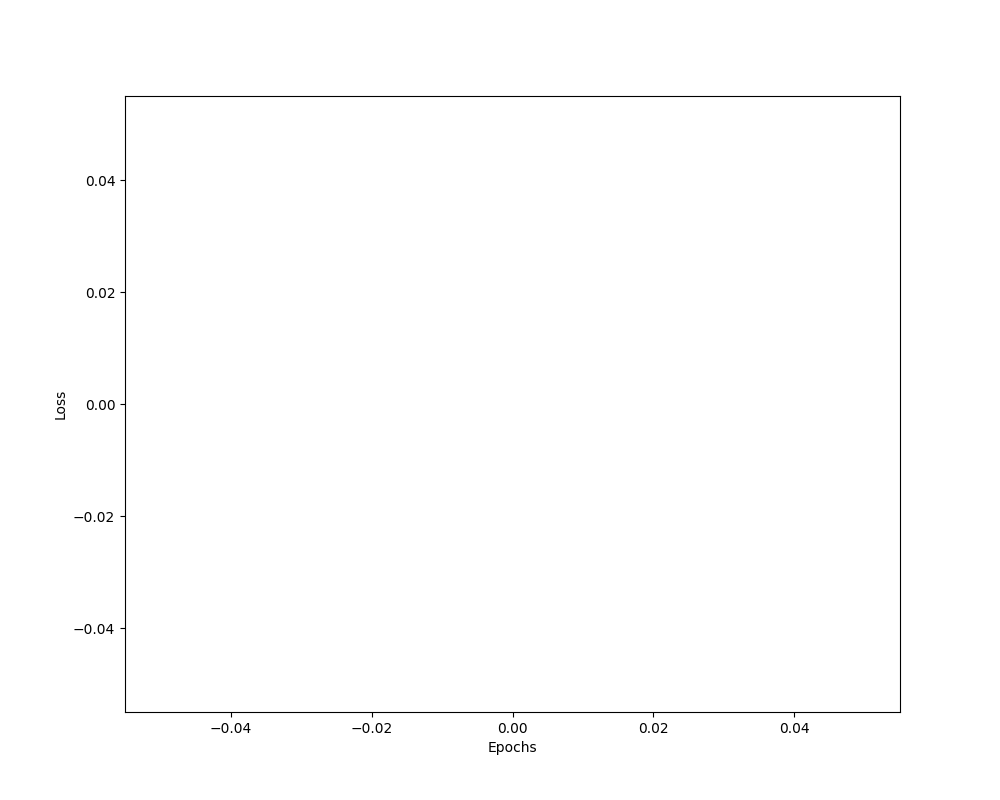

In [92]:
model, optm = setup_model()
if os.path.isfile(checkpoint_path):
    model.load_weights(checkpoint_path)
else:
    os.mknod(checkpoint_path)

area = get_area(grid_size, x_limits, y_limits)
border = get_border(border_grid_size, x_limits, y_limits)

train_loss_record = []
train_with_loss(area, border,
                model, optm)
# FIXME save weights, epoch is 0

model.save_weights(checkpoint_path)
plotting.NNPlots.plotLoss(train_loss_record)

In [93]:
"""
Preparing usefull arrays for plotting and accuracy calculation
"""
x = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[0])
y = np.linspace(y_limits[0], y_limits[1], plotting_grid_size[1])
x, y = np.meshgrid(x, y)
test_x = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[0])
test_y = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[1])
test_x, test_y = np.meshgrid(test_x, test_y)
train_u = real_u((x, y))
true_u = real_u((test_x, test_y))
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = model.predict(np.array(pred_coord)).ravel().reshape(plotting_grid_size[0], plotting_grid_size[1])

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/home/arnautov/projectPractice/pinn_puasson/src/plotting.py:74: UserWarning: The following kwargs were not used by contour: 'linestyle'
  real.contour(
/home/arnautov/projectPractice/pinn_puasson/src/plotting.py:95: UserWarning: The following kwargs were not used by contour: 'linestyle'
  pred.contour(


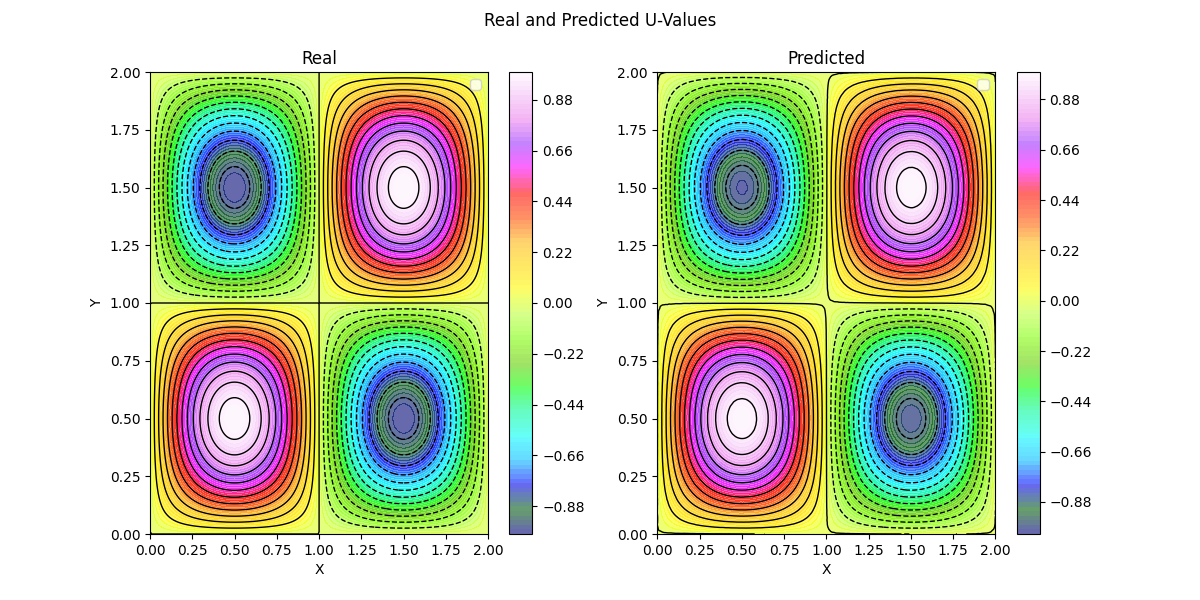

In [94]:
%matplotlib widget
plotter = plotting.NNPlots(test_x, test_y, true_u, x, y, pred_u, x_limits, y_limits)
# plotter.plot3d()
# plotter.plot2d_fix_x(3)

# cool cmaps: coolwarm(set as default), cool, gistncar, rainbow
plotter.plot2d_contour(color_map="gist_ncar", contour_levels=30)

# Accuracy calculation

In [95]:
from accuracy import AccuracyCalc

real_u(np.array([[1,2], [1,2]]))

calc = AccuracyCalc(model, real_u, area=np.array(pred_coord))
print("Accuracy:", calc.maape())

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
(40000,)
(40000,)
Accuracy: 0.0633149347555955
